In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import argparse
from create_reference_from_tsv_and_pepxml import ReferenceWriter
from sensitivity_calculator import SensitivityAndSpecificity
from create_PSM_df import PSM_FDR

In [2]:
def read_last_score(file):
    last_score = read_analysis_results_into_dict(file)['Hyperscore of last item in FDR boundaries:']
    return last_score

In [3]:
# psm score vs psm count for wrong plot
def get_psm_score_count(level_list, file_list, in_fdr=True, fdr=0.05):
    result = {}
    for level, file in zip(level_list, file_list):
        result_df = ReferenceWriter.read_csv_with_generic_function(file, ['Hyperscore', 'decoy'])
        result_df = result_df[['Title',  'Hyperscore', 'decoy']]
        if in_fdr:
            fdr_pos, number_psm, number_decoy, double_spectra, score_last_item = PSM_FDR.determine_FDR_position(result_df, fdr, True)
            result_df = result_df[0:fdr_pos]
        reversed_df = result_df.sort_values(by=['Hyperscore', 'Title'], ascending=True).reset_index(drop=True)
        # print(reversed_df.head(10))
        print('Dataframe loaded.')
        #psm count = len set(spectra)
        spectra_set=set()
        decoy_set=set()
        psm_score = []
        psm_count = []
        decoy_count = []
        decoy_score = []
        last_psm_score = 0
        last_decoy_score = 0
        for (spectra, score, decoy) in zip(reversed_df.Title.tolist(), reversed_df.Hyperscore.tolist(), reversed_df.decoy.tolist()):
            if decoy == {True}:
                decoy_set.add(spectra)
                if score == last_decoy_score:                
                    decoy_count[-1]=len(decoy_set)
                else:
                    decoy_score.append(score)
                    decoy_count.append(len(decoy_set))
                last_decoy_score = score
            else:          
                spectra_set.add(spectra)
                if score == last_psm_score:
                    psm_count[-1]=len(spectra_set)
                else:
                    psm_score.append(score)
                    psm_count.append(len(spectra_set))          
                last_psm_score = score
        result[level] = {'psm_count': psm_count, 'psm_score': psm_score, 'decoy_count': decoy_count, 'decoy_score':decoy_score}
    return result

In [4]:
level_list = ['species', 'genus', 'family']
color_list=['pink', 'red', 'purple']
uniprot_list = ["/home/jules/Documents/Tax2Proteome/benchmarking/results_searchgui_xtandem_analyzer_bachelor_thesis/uniprot/x_tandem_tsv/Run1_U1_2000ng_uniprot_species_nr.t.xml_reduced.tsv",
            "/home/jules/Documents/Tax2Proteome/benchmarking/results_searchgui_xtandem_analyzer_bachelor_thesis/uniprot/x_tandem_tsv/Run1_U1_2000ng_uniprot_genus_nr.t.xml_reduced.tsv",
            "/home/jules/Documents/Tax2Proteome/benchmarking/results_searchgui_xtandem_analyzer_bachelor_thesis/uniprot/x_tandem_tsv/Run1_U1_2000ng_uniprot_family_nr.t.xml_reduced.tsv"]
    
result_uniprot_all_scores = get_psm_score_count(level_list, uniprot_list, in_fdr=False)
result_uniprot_in_fdr_scores = get_psm_score_count(level_list, uniprot_list)

Dataframe loaded.
Dataframe loaded.
Dataframe loaded.
Number of PSMs: 47476
Number of decoys: 2498
double identified spectra 3322
Position FDR border/Number of PSMs: 53296
score last item: 24
Dataframe loaded.
Number of PSMs: 35571
Number of decoys: 1872
double identified spectra 4579
Position FDR border/Number of PSMs: 42022
score last item: 27
Dataframe loaded.
Number of PSMs: 34819
Number of decoys: 1832
double identified spectra 6609
Position FDR border/Number of PSMs: 43260
score last item: 28
Dataframe loaded.


In [5]:
level_list_ncbi = ['species', 'genus']
color_list_ncbi=['lightgreen', 'green',]
ncbi_list = ["/home/jules/Documents/Tax2Proteome/benchmarking/results_searchgui_xtandem_analyzer_bachelor_thesis/ncbi_kleiner/x_tandem_tsv/Run1_U1_2000ng_ncbi_kleiner_species.t.xml_reduced.tsv",
            "/home/jules/Documents/Tax2Proteome/benchmarking/results_searchgui_xtandem_analyzer_bachelor_thesis/ncbi_kleiner/x_tandem_tsv/Run1_U1_2000ng_ncbi_kleiner_genus.t.xml_reduced.tsv"]
    
result_ncbi_all_scores = get_psm_score_count(level_list, ncbi_list, in_fdr=False)
result_ncbi_in_fdr_scores = get_psm_score_count(level_list, ncbi_list)

Dataframe loaded.
Dataframe loaded.
Number of PSMs: 38647
Number of decoys: 2034
double identified spectra 3711
Position FDR border/Number of PSMs: 44392
score last item: 24
Dataframe loaded.
Number of PSMs: 35546
Number of decoys: 1870
double identified spectra 5675
Position FDR border/Number of PSMs: 43091
score last item: 27
Dataframe loaded.


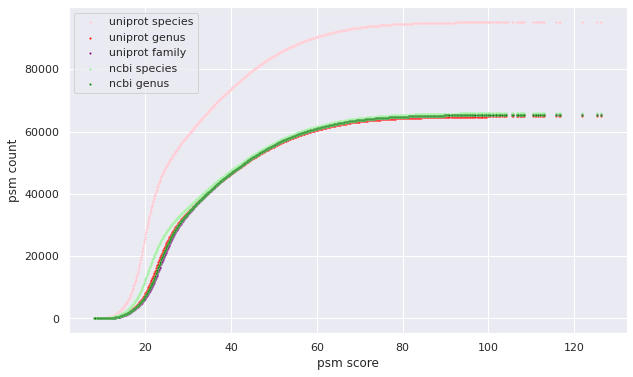

In [6]:
sns.set_theme(style="darkgrid")
plt.figure(figsize=(10,6))
#sns.lineplot/ pointplot(x="timepoint", y="signal",hue="region", style="event", data=fmri)
for c, level in zip(color_list, level_list):
    sns.scatterplot(x= result_uniprot_all_scores[level]['psm_score'], y=result_uniprot_all_scores[level]['psm_count'], color=c, 
                    label=f"uniprot {level}", s=5)
for c, level in zip(color_list_ncbi, level_list_ncbi):
    sns.scatterplot(x= result_ncbi_all_scores[level]['psm_score'], y=result_ncbi_all_scores[level]['psm_count'], color=c, 
                    label=f"ncbi {level}", s=5)

plt.ylabel("psm count")
plt.xlabel("psm score")
#plt.title('', size=20)
plt.savefig('/home/jules/Documents/Tax2Proteome/benchmarking/plots/uniprot_ncbi_psm_count_score_all.png')

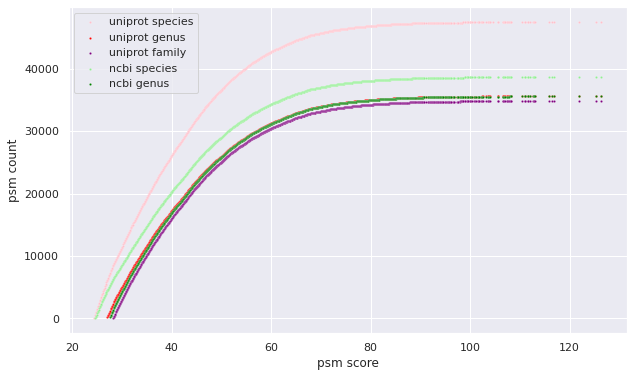

In [7]:

plt.figure(figsize=(10,6))
#sns.lineplot/ pointplot(x="timepoint", y="signal",hue="region", style="event", data=fmri)
for c, level in zip(color_list, level_list):
    sns.scatterplot(x= result_uniprot_in_fdr_scores[level]['psm_score'], y=result_uniprot_in_fdr_scores[level]['psm_count'], color=c, 
                    label=f"uniprot {level}", s=5)
for c, level in zip(color_list_ncbi, level_list_ncbi):
    sns.scatterplot(x= result_ncbi_in_fdr_scores[level]['psm_score'], y=result_ncbi_in_fdr_scores[level]['psm_count'], color=c, 
                    label=f"ncbi {level}", s=5)

plt.ylabel("psm count")
plt.xlabel("psm score")
#plt.title('', size=20)
plt.savefig('/home/jules/Documents/Tax2Proteome/benchmarking/plots/uniprot_ncbi_psm_count_score_in_fdr.png')

Number of PSMs: 47476
Number of decoys: 2498
double identified spectra 3322
Position FDR border/Number of PSMs: 53296
score last item: 24
Dataframe loaded.
Number of PSMs: 35571
Number of decoys: 1872
double identified spectra 4579
Position FDR border/Number of PSMs: 42022
score last item: 27
Dataframe loaded.
Number of PSMs: 34819
Number of decoys: 1832
double identified spectra 6609
Position FDR border/Number of PSMs: 43260
score last item: 28
Dataframe loaded.


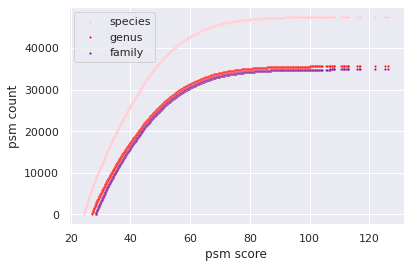

In [8]:
result = get_psm_score_count(level_list, uniprot_list, in_fdr=True)

sns.set_theme(style="darkgrid")
#sns.lineplot/ pointplot(x="timepoint", y="signal",hue="region", style="event", data=fmri)
for c, level in zip(color_list, level_list):
    sns.scatterplot(x= result[level]['psm_score'], y=result[level]['psm_count'], color=c, 
                    label=level, s=5)
plt.ylabel("psm count")
plt.xlabel("psm score")
#plt.title('', size=20)
plt.savefig('/home/jules/Documents/Tax2Proteome/benchmarking/plots/uniprot_psm_count_score_in_fdr.png')

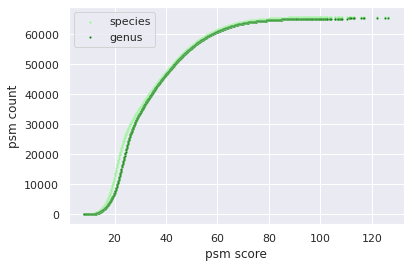

In [10]:
sns.set_theme(style="darkgrid")
#sns.lineplot/ pointplot(x="timepoint", y="signal",hue="region", style="event", data=fmri)
for c, level in zip(color_list_ncbi, level_list_ncbi):
    sns.scatterplot(x= result_ncbi_all_scores[level]['psm_score'], y=result_ncbi_all_scores[level]['psm_count'], color=c, 
                    label=level, s=5)
plt.ylabel("psm count")
plt.xlabel("psm score")
#plt.title('', size=20)
plt.savefig('/home/jules/Documents/Tax2Proteome/benchmarking/plots/ncbi_in_fdr_psm_count_score.png')

Dataframe loaded.
Dataframe loaded.


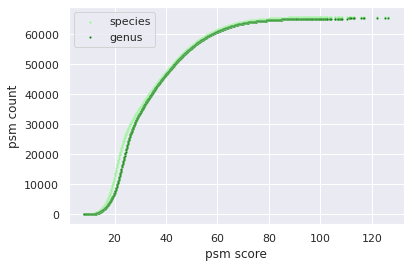

In [11]:
result_ncbi_all = get_psm_score_count(level_list, ncbi_list, in_fdr=False)

sns.set_theme(style="darkgrid")
#sns.lineplot/ pointplot(x="timepoint", y="signal",hue="region", style="event", data=fmri)
for c, level in zip(color_list_ncbi, level_list_ncbi):
    sns.scatterplot(x= result_ncbi_all[level]['psm_score'], y=result_ncbi_all[level]['psm_count'], color=c, 
                    label=level, s=5)
plt.ylabel("psm count")
plt.xlabel("psm score")
#plt.title('', size=20)
plt.savefig('/home/jules/Documents/Tax2Proteome/benchmarking/plots/ncbi_all_psm_count_score.png')

Number of PSMs: 27739
Number of decoys: 1459
double identified spectra 686
Position FDR border/Number of PSMs: 29884
score last item: 20
Dataframe loaded.
Number of PSMs: 28336
Number of decoys: 1491
double identified spectra 1011
Position FDR border/Number of PSMs: 30838
score last item: 21
Dataframe loaded.
Number of PSMs: 28477
Number of decoys: 1498
double identified spectra 1354
Position FDR border/Number of PSMs: 31329
score last item: 22
Dataframe loaded.
Number of PSMs: 27970
Number of decoys: 1472
double identified spectra 1936
Position FDR border/Number of PSMs: 31378
score last item: 23
Dataframe loaded.


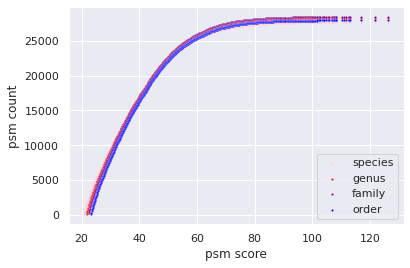

In [12]:
level_list = ['species', 'genus', 'family', 'order']
color_list=['pink', 'red', 'purple', 'blue']
swissprot_list = ["/home/jules/Documents/Tax2Proteome/benchmarking/results_searchgui_xtandem_analyzer_bachelor_thesis/swissprot/x_tandem_tsv/Run1_U1_2000ng_swissprot_species.t.xml_reduced.tsv",
            "/home/jules/Documents/Tax2Proteome/benchmarking/results_searchgui_xtandem_analyzer_bachelor_thesis/swissprot/x_tandem_tsv/Run1_U1_2000ng_swissprot_genus.t.xml_reduced.tsv",
            "/home/jules/Documents/Tax2Proteome/benchmarking/results_searchgui_xtandem_analyzer_bachelor_thesis/swissprot/x_tandem_tsv/Run1_U1_2000ng_swissprot_family.t.xml_reduced.tsv",
            "/home/jules/Documents/Tax2Proteome/benchmarking/results_searchgui_xtandem_analyzer_bachelor_thesis/swissprot/x_tandem_tsv/Run1_U1_2000ng_swissprot_order.t.xml_reduced.tsv"]
    
result = get_psm_score_count(level_list, swissprot_list)

sns.set_theme(style="darkgrid")
#sns.lineplot/ pointplot(x="timepoint", y="signal",hue="region", style="event", data=fmri)
for c, level in zip(color_list, level_list):
    sns.scatterplot(x= result[level]['psm_score'], y=result[level]['psm_count'], color=c, 
                    label=level, s=5)
plt.ylabel("psm count")
plt.xlabel("psm score")
#plt.title('', size=20)
plt.savefig('/home/jules/Documents/Tax2Proteome/benchmarking/plots/swissprot_in_fdr_psm_count_score.png')

Text(0.5, 0, 'decoy score')

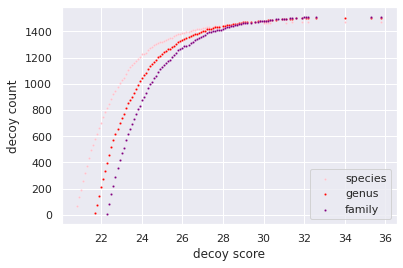

In [13]:
sns.set_theme(style="darkgrid")
#sns.lineplot(x="timepoint", y="signal",hue="region", style="event", data=fmri)
sns.scatterplot(x= result['species']['decoy_score'], y=result['species']['decoy_count'], color='pink', 
                label='species', s=5)
sns.scatterplot(x=result['genus']['decoy_score'], y=result['genus']['decoy_count'], color='red',
                label='genus', s=5)
sns.scatterplot(x=result['family']['decoy_score'], y=result['family']['decoy_count'], color='purple', 
                label='family', s=5)

plt.ylabel("decoy count")
plt.xlabel("decoy score")